# Load modules

In [1]:
%cd ~/Workspace/kaggle-2019Q3-cellular/

/home/chengjiun/Workspace/kaggle-2019Q3-cellular


In [2]:
import os
import numpy as np
import pandas as pd

from fastai.vision import *
BASE_DIR = '../DATA/kaggle-2019Q3-cellular/'


def open_rcic_image(fn):
    images = []
    for i in range(6):
        file_name = fn+str(i+1)+'.png'
        im = cv2.imread(file_name)
        if im is None: 
            print(f'file reading failed {file_name}')
        
        im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        images.append(im)
    image = np.dstack(images)
    #print(pil2tensor(image, np.float32).shape)#.div_(255).shape)
    return Image(pil2tensor(image, np.float32).div_(255))
  
class MultiChannelImageList(ImageList):
    def open(self, fn):
        return open_rcic_image(fn)
    
def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style."
    res = image.cpu().permute(1,2,0).numpy()
    if res.shape[2]==1:
        return res[...,0]  
    elif res.shape[2]>3:
        #print(res.shape)
        #print(res[...,:3].shape)
        return res[...,:3]
    else:
        return res

vision.image.image2np = image2np

## efficientnet

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import scipy as sp
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json

In [4]:
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding
model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=1108) 

def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {
    'efficientnet-b0': 'http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth',
    'efficientnet-b1': 'http://storage.googleapis.com/public-models/efficientnet-b1-dbc7070a.pth',
    'efficientnet-b2': 'http://storage.googleapis.com/public-models/efficientnet-b2-27687264.pth',
    'efficientnet-b3': 'http://storage.googleapis.com/public-models/efficientnet-b3-c8376fa2.pth',
    'efficientnet-b4': 'http://storage.googleapis.com/public-models/efficientnet-b4-e116e8b3.pth',
    'efficientnet-b5': 'http://storage.googleapis.com/public-models/efficientnet-b5-586e6cc6.pth',
    'efficientnet-b6': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b7-dcc49843.pth',
}

def load_pretrained_weights(model, model_name, load_fc=True):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    state_dict = model_zoo.load_url(url_map[model_name])
    if load_fc:
        model.load_state_dict(state_dict)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        res = model.load_state_dict(state_dict, strict=False)
        assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))
            

# Set seed fol all
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    


seed_everything()

Loaded pretrained weights for efficientnet-b6


## utils

In [5]:
#lazy calculation of stats
pixel_stats = pd.read_csv(f'{BASE_DIR}/pixel_stats.csv')
channel1_mean = pixel_stats.iloc[::6,:]['mean'].mean()
channel2_mean = pixel_stats.iloc[1::6,:]['mean'].mean()
channel3_mean = pixel_stats.iloc[2::6,:]['mean'].mean()
channel4_mean = pixel_stats.iloc[3::6,:]['mean'].mean()
channel5_mean = pixel_stats.iloc[4::6,:]['mean'].mean()
channel6_mean = pixel_stats.iloc[5::6,:]['mean'].mean()


channel1_std = pixel_stats.iloc[::6,:]['std'].mean()
channel2_std = pixel_stats.iloc[1::6,:]['std'].mean()
channel3_std = pixel_stats.iloc[2::6,:]['std'].mean()
channel4_std = pixel_stats.iloc[3::6,:]['std'].mean()
channel5_std = pixel_stats.iloc[4::6,:]['std'].mean()
channel6_std = pixel_stats.iloc[5::6,:]['std'].mean()
stats = (torch.Tensor([channel1_mean,channel2_mean,channel3_mean,channel4_mean,channel5_mean,channel6_mean])/255,torch.Tensor([channel1_std,channel2_std,channel3_std,channel4_std,channel5_std,channel6_std])/255)
print(stats)

(tensor([0.0229, 0.0611, 0.0396, 0.0391, 0.0219, 0.0356]), tensor([0.0271, 0.0492, 0.0219, 0.0292, 0.0183, 0.0193]))


## Loading and formatting data

Here I will load the csv into the DataFrame, and create a column in the DataFrame with the path to the corresponding image (`generate_df`)

In [6]:
train_df = pd.read_csv(f'{BASE_DIR}/train.csv')
train_df.head(10)

,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144
5,HEPG2-01_1_B08,HEPG2-01,1,B08,503
6,HEPG2-01_1_B09,HEPG2-01,1,B09,188
7,HEPG2-01_1_B10,HEPG2-01,1,B10,700
8,HEPG2-01_1_B11,HEPG2-01,1,B11,1100
9,HEPG2-01_1_B12,HEPG2-01,1,B12,611


In [7]:
from sklearn.model_selection import train_test_split


exp_list = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']
def generate_df(train_df,sample_num=[1,2],exp=None, test_size=None, random_state=42):
    train_df['is_valid'] = False
    if exp is not None:
        train_df = train_df[train_df['exp'] == exp]
        print(f'extract experiment: {exp}, number of train data {len(train_df)}')
    if test_size is not None:
        sub_train_df, sub_test_df = train_test_split(train_df, test_size=test_size, random_state=random_state)
        sub_test_df.loc[:, 'is_valid'] = True
        train_df = pd.concat([sub_train_df, sub_test_df], axis=0, sort=False)
    
    temp_df = train_df.drop(columns=['id_code','experiment','plate','well'])
    res_df = pd.DataFrame()
    for s in sample_num:
        temp_df['path'] = (train_df['experiment'].str.cat(train_df['plate'].astype(str)
                                                .str.cat(train_df['well'],sep='/'),sep='/Plate') + '_s'+str(s) + '_w')
        
        temp_df = temp_df.reindex(columns=['path','sirna', 'is_valid'])
        if len(res_df) ==0:
            res_df = temp_df.copy(deep=True)
        else:
            res_df = pd.concat([temp_df, res_df], axis=0, sort=False)
            
    return res_df

proc_train_all_df = generate_df(train_df, sample_num=[1,2], exp=None, test_size=0.1)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
proc_train_all_df.head(10)

,path,sirna,is_valid
24735,HUVEC-16/Plate2/H14_s2_w,694,False
33693,U2OS-01/Plate2/M13_s2_w,128,False
20160,HUVEC-12/Plate1/M12_s2_w,272,False
24447,HUVEC-16/Plate1/G22_s2_w,450,False
8517,HUVEC-01/Plate3/L20_s2_w,255,False
5686,HEPG2-06/Plate1/I17_s2_w,459,False
35838,U2OS-03/Plate2/I21_s2_w,639,False
24541,HUVEC-16/Plate1/L18_s2_w,162,False
23079,HUVEC-14/Plate4/H02_s2_w,334,False
5186,HEPG2-05/Plate3/L11_s2_w,48,False


In [9]:
il = MultiChannelImageList.from_df(df=proc_train_all_df,path='../DATA/kaggle-2019Q3-cellular/train/')

## Creating and Training a Model

I will use a pretrained ResNet. I have to now adjust the CNN arch to take in 6 channels as opposed to the usual 3 channels:

In [10]:
"""Inspired by https://github.com/wdhorton/protein-atlas-fastai/blob/master/resnet.py"""

import torchvision
RESNET_MODELS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
    '101x': torchvision.models.resnext101_32x8d,
}


def resnet_multichannel(depth=50,pretrained=True,num_classes=1108,num_channels=6):
    model = RESNET_MODELS[depth](pretrained=pretrained)
    w = model.conv1.weight
    model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                           bias=False)
    model.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,num_channels-3,7,7)),dim=1))
    return model

def efficientnetb4_multichannel(name='efficientnet-b4', pretrained=True, num_classes=1108, num_channels=6):
    model = EfficientNet.from_pretrained(name, num_classes)
    load_pretrained_weights(model,model_name=name, load_fc=False)
    w = model._conv_stem.weight
    model._conv_stem = Conv2dStaticSamePadding(num_channels, 48, kernel_size=3, 
                                               image_size=image_size, stride=2, padding=3)
    model._conv_stem.weight = nn.Parameter(torch.cat((w,torch.zeros(48,num_channels-3,3,3)),dim=1))
    return model

def efficientnetb6_multichannel(name='efficientnet-b6', pretrained=True, num_classes=1108, num_channels=6):
    model = EfficientNet.from_pretrained(name, num_classes)
    load_pretrained_weights(model,model_name=name, load_fc=False)
    w = model._conv_stem.weight
    model._conv_stem = Conv2dStaticSamePadding(num_channels, 56, kernel_size=3, 
                                               image_size=image_size, stride=2, padding=3)
    model._conv_stem.weight = nn.Parameter(torch.cat((w,torch.zeros(56,num_channels-3,3,3)),dim=1))
    return model

In [11]:
image_size=512
def resnet34(pretrained,num_channels=6):
    return resnet_multichannel(depth=50,pretrained=pretrained,num_channels=num_channels)

def resnet50(pretrained,num_channels=6):
    return resnet_multichannel(depth=50,pretrained=pretrained,num_channels=num_channels)

def resnext101(pretrained,num_channels=6):
    return resnet_multichannel(depth='101x',pretrained=pretrained,num_channels=num_channels)

effnetb4 = efficientnetb4_multichannel('efficientnet-b4', pretrained=True,num_channels=6)

effnetb6 = efficientnetb6_multichannel('efficientnet-b6', pretrained=True,num_channels=6)

def _resnet_split(m): return (m[0][6],m[1])

Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b6
Loaded pretrained weights for efficientnet-b6


In [12]:
"""From https://www.kaggle.com/leighplt/densenet121-pytorch"""
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return torch.Tensor(np.array(res))

Let's create our Learner:

In [39]:
del learn
del data
torch.cuda.empty_cache()


NameError: name 'learn' is not defined

In [13]:
from optim.ranger import Ranger
optar = partial(Ranger)

In [14]:
# 1080Ti 9G: img size=384, efficientnet-b4, bs=16
# 4Ti
proc_train_all_df = generate_df(train_df, sample_num=[1,2], exp=None, test_size=0.1)

image_size=512
tfms = get_transforms(do_flip=True, flip_vert=True,
                      max_lighting=0.2, p_lighting=0.5, 
                      max_warp=0., max_rotate=20., max_zoom=1.0)

data = (MultiChannelImageList.from_df(df=proc_train_all_df,path='../DATA/kaggle-2019Q3-cellular/train/')
        .split_from_df(col=2)
        .label_from_df()
        .transform(tfms,size=image_size)
        .databunch(bs=8,num_workers=8)
        .normalize(stats)
       )

In [15]:
learn = Learner(data, 
                effnetb6, opt_func=optar,
                metrics = [accuracy], 
                model_dir='./fastaimodels').to_fp16()
# learn.model = torch.nn.DataParallel(learn.model)
learn.path = Path('./effb6-gce')


We can now find the appropriate learning rate and train the head of the model:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 7.59E-08


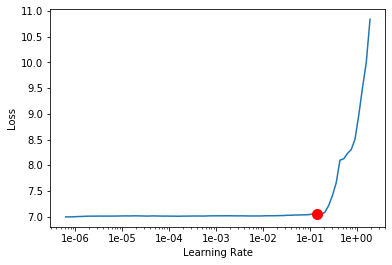

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
learn.load('bestmodel_1')

Learner(data=ImageDataBunch;

Train: LabelList (32864 items)
x: MultiChannelImageList
Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512)
y: CategoryList
513,840,1020,254,144
Path: ../DATA/kaggle-2019Q3-cellular/train;

Valid: LabelList (3651 items)
x: MultiChannelImageList
Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512)
y: CategoryList
243,460,194,548,482
Path: ../DATA/kaggle-2019Q3-cellular/train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    6, 48, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3)
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_

In [17]:
learn.fit_one_cycle(5,1e-3, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,6.105277,6.235867,2.505476,2:13:59
1,4.868672,5.444077,14.293538,2:14:58
2,3.841510,4.026797,26.533407,2:14:41
3,3.174592,3.202556,46.207558,2:14:07
4,2.545732,3.268396,48.904709,2:14:10


In [18]:
learn.save('effnetb6-512-stage1')
learn.export()

We will now unfreeze and train the entire model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.10E-03


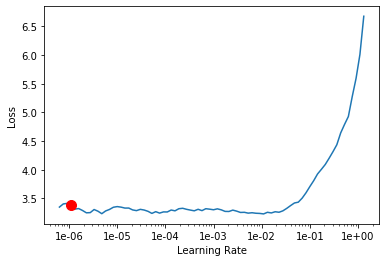

In [28]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [19]:
learn.fit_one_cycle(5,1e-4, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,2.614366,2.951891,49.589268,2:14:13
1,2.498158,2.418390,51.396496,2:14:03
2,2.355035,2.268380,53.381710,2:14:21
3,2.263090,2.192098,54.696056,2:14:20
4,2.067549,2.122808,55.243702,2:14:28


Better model found at epoch 0 with accuracy value: 49.58926773071289.
Better model found at epoch 1 with accuracy value: 51.3964958190918.
Better model found at epoch 2 with accuracy value: 53.381710052490234.
Better model found at epoch 3 with accuracy value: 54.6960563659668.
Better model found at epoch 4 with accuracy value: 55.24370193481445.


In [20]:
learn.save('effnetb6-512-stage2')
learn.export()

In [21]:
learn.fit_one_cycle(5,1e-4, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,2.089190,2.232983,54.627602,2:14:01
1,2.211014,2.243691,54.572838,2:14:26
2,2.046103,2.019142,57.584885,2:14:39
3,1.836306,1.901802,59.104599,2:14:43
4,1.820021,1.955300,58.707558,2:14:42


Better model found at epoch 0 with accuracy value: 54.627601623535156.
Better model found at epoch 2 with accuracy value: 57.58488464355469.
Better model found at epoch 3 with accuracy value: 59.10459899902344.


In [22]:
learn.save('effnetb6-512-stage2')
learn.export()

## split sites

In [23]:
proc_train_s1_df = generate_df(train_df, sample_num=[1], exp=None, test_size=0.2, random_state=1)

image_size=512
tfms1 = get_transforms(do_flip=True, flip_vert=True,
                      max_lighting=0.2, p_lighting=0.5, 
                      max_warp=0.05, max_rotate=20., max_zoom=1.1)

data = (MultiChannelImageList.from_df(df=proc_train_s1_df,path='../DATA/kaggle-2019Q3-cellular/train/')
        .split_from_df(col=2)
        .label_from_df()
        .transform(tfms1,size=image_size)
        .databunch(bs=8,num_workers=8)
        .normalize(stats)
       )

learn = Learner(data, 
                effnetb6, opt_func=optar,
                metrics = [accuracy], 
                model_dir='./fastaimodels').to_fp16()
# learn.model = torch.nn.DataParallel(learn.model)
learn.path = Path('./effb6-gce')
learn.load('effnetb6-512-stage2')

Learner(data=ImageDataBunch;

Train: LabelList (29212 items)
x: MultiChannelImageList
Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512)
y: CategoryList
560,221,395,976,356
Path: ../DATA/kaggle-2019Q3-cellular/train;

Valid: LabelList (7303 items)
x: MultiChannelImageList
Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512)
y: CategoryList
582,908,282,507,963
Path: ../DATA/kaggle-2019Q3-cellular/train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    6, 56, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3)
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
        (static_p

In [24]:
learn.unfreeze()
learn.fit_one_cycle(5,1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.906088,1.290788,71.655487,1:02:12
1,2.050498,1.309538,71.518555,1:03:11
2,2.083158,1.331794,71.395317,1:03:55
3,1.954107,1.268357,72.066277,1:03:53
4,1.820337,1.262773,72.285362,1:03:59


In [25]:
learn.save('effnetb6-512-s1-stage3')
learn.export()

In [26]:
proc_train_s2_df = generate_df(train_df, sample_num=[2], exp=None, test_size=0.2, random_state=2)

image_size=512
tfms2 = get_transforms(do_flip=True, flip_vert=True,
                      max_lighting=0.2, p_lighting=0.5, 
                      max_warp=0.05, max_rotate=20., max_zoom=1.1)

data = (MultiChannelImageList.from_df(df=proc_train_s2_df,path='../DATA/kaggle-2019Q3-cellular/train/')
        .split_from_df(col=2)
        .label_from_df()
        .transform(tfms2,size=image_size)
        .databunch(bs=8,num_workers=8)
        .normalize(stats)
       )

learn = Learner(data, 
                effnetb6, opt_func=optar,
                metrics = [accuracy], 
                model_dir='./fastaimodels').to_fp16()
# learn.model = torch.nn.DataParallel(learn.model)
learn.path = Path('./effb6-gce')
learn.load('effnetb6-512-stage2')

Learner(data=ImageDataBunch;

Train: LabelList (29212 items)
x: MultiChannelImageList
Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512)
y: CategoryList
295,860,439,361,683
Path: ../DATA/kaggle-2019Q3-cellular/train;

Valid: LabelList (7303 items)
x: MultiChannelImageList
Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512)
y: CategoryList
209,961,903,419,850
Path: ../DATA/kaggle-2019Q3-cellular/train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    6, 56, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3)
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
        (static_p

In [27]:
learn.unfreeze()
learn.fit_one_cycle(5,1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.067191,1.301887,71.148842,1:01:57
1,2.138493,1.272404,71.765030,1:02:27
2,2.034604,1.221119,72.079964,1:03:44
3,1.918851,1.278515,71.970421,1:04:31
4,2.085001,1.246168,71.792412,1:04:19


In [29]:
learn.save('effnetb6-512-s2-stage3')
learn.export()

## Inference and Submission Generation

In [17]:
def generate_submission(preds_score, name='submission-effB4-384-singlesite.csv'):
    submission_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')
    result = preds_score.argmax(dim=-1)
    submission_df.sirna = result.numpy().astype(int)
    submission_df.to_csv(name,index=False)
    print(f'write to submission_df {name}')
    return submission_df

test_df = pd.read_csv(f'{BASE_DIR}/test.csv')

###  all data

In [31]:
proc_train_all_df = generate_df(train_df, sample_num=[1,2], exp=None, test_size=0.1)

image_size=512
tfms = get_transforms(do_flip=True, flip_vert=True,
                      max_lighting=0.2, p_lighting=0.5, 
                      max_warp=0., max_rotate=20., max_zoom=1.0)

data = (MultiChannelImageList.from_df(df=proc_train_all_df,path='../DATA/kaggle-2019Q3-cellular/train/')
        .split_from_df(col=2)
        .label_from_df()
        .transform(tfms,size=image_size)
        .databunch(bs=8,num_workers=8)
        .normalize(stats)
       )
learn.load('effnetb6-512-stage2-best')

Learner(data=ImageDataBunch;

Train: LabelList (29212 items)
x: MultiChannelImageList
Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512)
y: CategoryList
295,860,439,361,683
Path: ../DATA/kaggle-2019Q3-cellular/train;

Valid: LabelList (7303 items)
x: MultiChannelImageList
Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512)
y: CategoryList
209,961,903,419,850
Path: ../DATA/kaggle-2019Q3-cellular/train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    6, 56, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3)
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
        (static_p

In [32]:

proc_test_df = generate_df(test_df.copy(), sample_num=[1])
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)
preds, _ = learn.get_preds(DatasetType.Test)
preds_ = preds.argmax(dim=-1)

In [33]:
proc_test_df = generate_df(test_df.copy(), sample_num=[2])
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)
preds2, _ = learn.get_preds(DatasetType.Test)
preds2_ = preds2.argmax(dim=-1)

In [34]:
preds_mean = (preds + preds2)/2.

In [45]:
## local CV: 0.46 single site
sub_s1_df = generate_submission(preds, name='submission-effB4-384-singlesite.csv')
sub_s1_df.head()

In [46]:
## local CV: 0.46
sub_2site_df = generate_submission(preds_mean, name='submission-effB4-384-doublesite.csv')

sub_2site_df.head(10)

,id_code,sirna
0,HEPG2-08_1_B03,468
1,HEPG2-08_1_B04,7
2,HEPG2-08_1_B05,1091
3,HEPG2-08_1_B06,908
4,HEPG2-08_1_B07,135
5,HEPG2-08_1_B08,981
6,HEPG2-08_1_B09,118
7,HEPG2-08_1_B10,638
8,HEPG2-08_1_B11,807
9,HEPG2-08_1_B12,778


In [35]:
## local CV: 0.59 single site
sub_s1_df = generate_submission(preds, name='submission-effB6-512-singlesite.csv')
sub_s1_df.head()

write to submission_df submission-effB6-512-singlesite.csv


,id_code,sirna
0,HEPG2-08_1_B03,381
1,HEPG2-08_1_B04,637
2,HEPG2-08_1_B05,506
3,HEPG2-08_1_B06,609
4,HEPG2-08_1_B07,43


In [36]:
## local CV: 0.59
sub_2site_df = generate_submission(preds_mean, name='submission-effB6-512-doublesite.csv')
sub_2site_df.head(10)


write to submission_df submission-effB6-512-doublesite.csv


,id_code,sirna
0,HEPG2-08_1_B03,381
1,HEPG2-08_1_B04,637
2,HEPG2-08_1_B05,506
3,HEPG2-08_1_B06,706
4,HEPG2-08_1_B07,43
5,HEPG2-08_1_B08,37
6,HEPG2-08_1_B09,430
7,HEPG2-08_1_B10,638
8,HEPG2-08_1_B11,154
9,HEPG2-08_1_B12,1064


### try TTA  (half doesn't support) 

In [15]:
proc_train_all_df = generate_df(train_df, sample_num=[1,2], exp=None, test_size=0.1)

image_size=512
tfms = get_transforms(do_flip=True, flip_vert=True,
                      max_lighting=0.2, p_lighting=0.5, 
                      max_warp=0., max_rotate=20., max_zoom=1.0)

data = (MultiChannelImageList.from_df(df=proc_train_all_df,path='../DATA/kaggle-2019Q3-cellular/train/')
        .split_from_df(col=2)
        .label_from_df()
        .transform(tfms,size=image_size)
        .databunch(bs=8,num_workers=8)
        .normalize(stats)
       )
learn = Learner(data, 
                effnetb6, opt_func=optar,
                metrics = [accuracy], 
                model_dir='./fastaimodels').to_fp16()
# learn.model = torch.nn.DataParallel(learn.model)
learn.path = Path('./effb6-gce')

learn.load('effnetb6-512-stage2-best')

Learner(data=ImageDataBunch;

Train: LabelList (65726 items)
x: MultiChannelImageList
Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512)
y: CategoryList
694,128,272,450,255
Path: ../DATA/kaggle-2019Q3-cellular/train;

Valid: LabelList (7304 items)
x: MultiChannelImageList
Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512),Image (6, 512, 512)
y: CategoryList
255,1080,469,247,638
Path: ../DATA/kaggle-2019Q3-cellular/train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    6, 56, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3)
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
        (static_

In [ ]:
proc_test_df = generate_df(test_df.copy(), sample_num=[1])

data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)
preds_tta, _ = learn.TTA(ds_type=DatasetType.Test, scale=1.1)

In [ ]:
## local CV: 0.59 single site + TTA
sub_s1_tta_df = generate_submission(preds_tta, name='submission-effB6-512-TTA-singlesite.csv')
sub_s1_tta_df.head()

In [ ]:
proc_test_df = generate_df(test_df.copy(), sample_num=[2])
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)
preds2_tta, _ = learn.TTA(ds_type=DatasetType.Test)
preds_tta_mean = (preds_tta + preds2_tta)/2.

In [ ]:
## local CV: 0.59 double site + TTA
sub_2sites_tta_df = generate_submission(preds_tta_mean, name='submission-effB6-512-TTA-doublesite.csv')
sub_2sites_tta_df.head()

## two sites model

In [45]:
image_size=512
proc_train_s2_df = generate_df(train_df, sample_num=[2], exp=None, test_size=0.2, random_state=2)
tfms2 = get_transforms(do_flip=True, flip_vert=True,
                      max_lighting=0.2, p_lighting=0.5, 
                      max_warp=0.05, max_rotate=20., max_zoom=1.1)

data = (MultiChannelImageList.from_df(df=proc_train_s2_df,path='../DATA/kaggle-2019Q3-cellular/train/')
        .split_from_df(col=2)
        .label_from_df()
        .transform(tfms2,size=image_size)
        .databunch(bs=8,num_workers=8)
        .normalize(stats)
       )

learn = Learner(data, 
                effnetb6, opt_func=optar,
                metrics = [accuracy], 
                model_dir='./fastaimodels').to_fp16()
# learn.model = torch.nn.DataParallel(learn.model)
learn.path = Path('./effb6-gce')
learn.load('effnetb6-512-s2-stage3')


test_df = pd.read_csv(f'{BASE_DIR}/test.csv')
proc_test_df = generate_df(test_df.copy(), sample_num=[1])
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)
preds_s2, _ = learn.get_preds(DatasetType.Test)
preds_s2_ = preds_s2.argmax(dim=-1)

proc_test_df = generate_df(test_df.copy(), sample_num=[2])
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)
preds2_s2, _ = learn.get_preds(DatasetType.Test)
preds2_s2_ = preds2_s2.argmax(dim=-1)

In [44]:
image_size=512
proc_train_s1_df = generate_df(train_df, sample_num=[1], exp=None, test_size=0.2, random_state=2)
tfms2 = get_transforms(do_flip=True, flip_vert=True,
                      max_lighting=0.2, p_lighting=0.5, 
                      max_warp=0.05, max_rotate=20., max_zoom=1.1)

data = (MultiChannelImageList.from_df(df=proc_train_s1_df,path='../DATA/kaggle-2019Q3-cellular/train/')
        .split_from_df(col=2)
        .label_from_df()
        .transform(tfms2,size=image_size)
        .databunch(bs=8,num_workers=8)
        .normalize(stats)
       )

learn = Learner(data, 
                effnetb6, opt_func=optar,
                metrics = [accuracy], 
                model_dir='./fastaimodels').to_fp16()
# learn.model = torch.nn.DataParallel(learn.model)
learn.path = Path('./effb6-gce')
learn.load('effnetb6-512-s1-stage3')


test_df = pd.read_csv(f'{BASE_DIR}/test.csv')
proc_test_df = generate_df(test_df.copy(), sample_num=[1])
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)
preds_s1, _ = learn.get_preds(DatasetType.Test)
preds_s1_ = preds_s1.argmax(dim=-1)

proc_test_df = generate_df(test_df.copy(), sample_num=[2])
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)
preds2_s1, _ = learn.get_preds(DatasetType.Test)
preds2_s1_ = preds2_s1.argmax(dim=-1)

In [50]:
## local CV: 0.59
preds_mean_2sites = (preds_s1 + preds2_s1 + preds_s2 + preds2_s2)/4.
sub_model2site_df = generate_submission(preds_mean_2sites, name='submission-effB6-512-2sites.doublesite.csv')
sub_model2site_df.head(10)


write to submission_df submission-effB6-512-2sites.doublesite.csv


,id_code,sirna
0,HEPG2-08_1_B03,381
1,HEPG2-08_1_B04,637
2,HEPG2-08_1_B05,506
3,HEPG2-08_1_B06,706
4,HEPG2-08_1_B07,43
5,HEPG2-08_1_B08,37
6,HEPG2-08_1_B09,430
7,HEPG2-08_1_B10,638
8,HEPG2-08_1_B11,154
9,HEPG2-08_1_B12,1064


In [51]:
(sub_2site_df['sirna'] != sub_model2site_df['sirna']).mean()

0.17228727948937025

## self-boost

In [56]:
sub_df = pd.read_csv('submission-527.csv')

In [57]:
plate_groups = np.zeros((1108,4), int)
for sirna in range(1108):
    grp = train_df.loc[train_df.sirna==sirna,:].plate.value_counts().index.values
    assert len(grp) == 3
    plate_groups[sirna,0:3] = grp
    plate_groups[sirna,3] = 10 - grp.sum()
    


all_test_exp = test_df.experiment.unique()
group_plate_probs = np.zeros((len(all_test_exp),4))
for idx in range(len(all_test_exp)):
    preds = sub_df.loc[test_df.experiment == all_test_exp[idx],'sirna'].values
    pp_mult = np.zeros((len(preds),1108))
    pp_mult[range(len(preds)),preds] = 1
    
    sub_test = test_df.loc[test_df.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    
    for j in range(4):
        mask = np.repeat(plate_groups[np.newaxis, :, j], len(pp_mult), axis=0) == \
               np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
        
        group_plate_probs[idx,j] = np.array(pp_mult)[mask].sum()/len(pp_mult)

exp_to_group = group_plate_probs.argmax(1)
print(exp_to_group)


def select_plate_group(pp_mult, idx, 
                       test_df=test_df, all_test_exp=all_test_exp, plate_groups=plate_groups,
                       exp_to_group=exp_to_group):
    sub_test = test_df.loc[test_df.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    mask = np.repeat(plate_groups[np.newaxis, :, exp_to_group[idx]], len(pp_mult), axis=0) != \
           np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
    pp_mult[mask] = 0
    return pp_mult

[3 1 0 0 0 0 2 2 3 0 0 3 1 0 0 0 2 3]


In [58]:
def apply_boost(sub_df, preds_mean, 
                all_test_exp=all_test_exp, test_df=test_df, 
                plate_groups=plate_groups, exp_to_group=exp_to_group):
    for idx in range(len(all_test_exp)):
        #print('Experiment', idx)
        indices = (test_df.experiment == all_test_exp[idx])

        preds_slice = preds_mean.numpy()[indices,:].copy()

        preds_slice = select_plate_group(preds_slice, idx, 
                                         test_df=test_df, all_test_exp=all_test_exp, plate_groups=plate_groups,
                                         exp_to_group=exp_to_group)
        sub_df.loc[indices,'sirna'] = preds_slice.argmax(1)

    return sub_df

In [42]:
sub_df = apply_boost(sub_df, preds_mean)
sub_df.to_csv('submission-effB6-512-doublesite.boosted431.csv',index=False)
sub_df.head()

,id_code,sirna
0,HEPG2-08_1_B03,688
1,HEPG2-08_1_B04,710
2,HEPG2-08_1_B05,836
3,HEPG2-08_1_B06,609
4,HEPG2-08_1_B07,420


In [55]:
sub_df = apply_boost(sub_df, preds_tta_mean)
sub_df.to_csv('submission-effB6-512-TTA-doublesite.boosted431.csv',index=False)
sub_df.head()

0.0

In [59]:
sub_df = apply_boost(sub_df, preds_mean_2sites)
sub_df.to_csv('submission-effB6-512-2sites.doublesite.boosted527.csv',index=False)
sub_df.head()

,id_code,sirna
0,HEPG2-08_1_B03,141
1,HEPG2-08_1_B04,710
2,HEPG2-08_1_B05,836
3,HEPG2-08_1_B06,609
4,HEPG2-08_1_B07,420
